# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import librosa
import mir_eval

import audio_functions as af
import audio_models
import dataset

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


### Get the variables and data ready

In [2]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = False

checkpoint = '71/71-2000'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_spec_trim = mixed_spec[:, :, :-1, :]
voice_spec_trim = voice_spec[:, :, :-1, :]

In [3]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [4]:
# Build U-Net model
print('Creating model')
model = audio_models.ComplexNumberModel(mixed_spec_trim, voice_spec_trim, mixed_audio, voice_audio,
                                                'capsunet', is_training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [5]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/71/71-2000


### Run a batch

In [6]:
mix_spec, voice_ref_spec, voice_est_spec, \
voice_ref_wave, mix_wave, mask = sess.run([tf.complex(model.mixed_spec[:, :, :, 0], model.mixed_spec[:, :, :, 1]), 
                                           tf.complex(model.voice_spec[:, :, :, 0], model.voice_spec[:, :, :, 1]),
                                           tf.complex(model.gen_voice[:, :, :, 0], model.gen_voice[:, :, :, 1]), 
                                           model.voice_audio, 
                                           model.mixed_audio,
                                           tf.complex(model.voice_mask[:, :, :, 0], model.voice_mask[:, :, :, 1])],
                                          {model.is_training:False})
voice_est_wave = list()

for i in range(voice_est_spec.shape[0]):
    voice_est_wave.append(librosa.istft(voice_est_spec[i, :, :].T, fft_hop))


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [7]:
i=3
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
65280


In [8]:
# Estimate the background noise by subtracting the isolated voice and estimated voice from the mixture
bg_ref_mag = np.abs(mix_spec) - np.abs(voice_ref_spec)
bg_est_mag = np.abs(mix_spec) - np.abs(voice_est_spec)
mix_phase = np.angle(mix_spec)

bg_ref_wave = list()
bg_est_wave = list()

for i in range(bg_ref_mag.shape[0]):
    bg_ref_wave.append(af.spectrogramToAudioFile(bg_ref_mag[i, :, :].T,
                                                 n_fft, fft_hop,
                                                 phaseIterations=0,
                                                 phase=mix_phase[i, :, :].T))
    bg_est_wave.append(af.spectrogramToAudioFile(bg_est_mag[i, :, :].T,
                                                 n_fft, fft_hop,
                                                 phaseIterations=0,
                                                 phase=mix_phase[i, :, :].T))

In [9]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
for i in range(batch_size):
    ref_sources.append(np.concatenate((voice_ref_wave[i], np.expand_dims(bg_ref_wave[i], axis=1)), axis=1))
    est_sources.append(np.concatenate((np.expand_dims(voice_est_wave[i], axis=1), np.expand_dims(bg_est_wave[i], axis=1)), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[ 8.03187286 14.20902079]
 [ 9.96889747 15.31522589]
 [ 8.20020041 14.31667969]
 [11.35047834 17.25578924]
 [ 3.22242727 13.02719234]] 
SIR
 [[10.03502703 15.69862307]
 [13.71316477 18.1735756 ]
 [10.99347703 15.89870752]
 [12.37574843 17.92244364]
 [ 4.04227817 14.27530617]] 
SAR
 [[12.76647399 19.69507665]
 [12.53240509 18.54862167]
 [11.7713783  19.5796625 ]
 [18.36680069 25.793201  ]
 [12.30980811 19.2109326 ]]


In [10]:
mask.shape

(5, 256, 512)

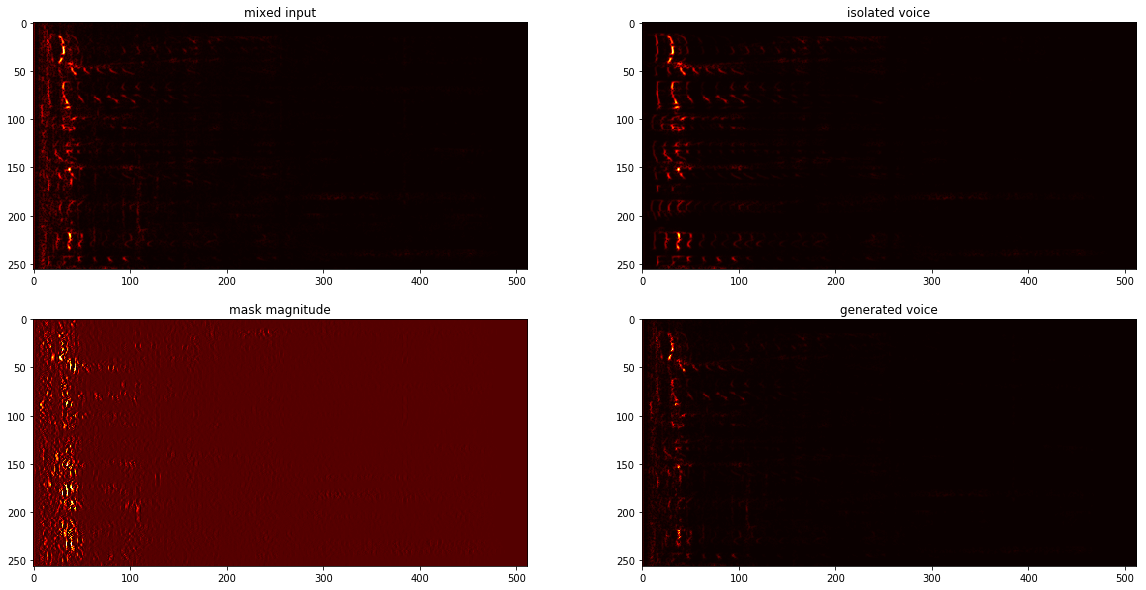

In [11]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(np.abs(mix_spec[i,:,:]))
ax[0,0].set_title('mixed input')
ax[0,1].imshow(np.abs(voice_ref_spec[i,:,:]))
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(np.abs(mask[i,:,:]))
ax[1,0].set_title('mask magnitude')
ax[1,1].imshow(np.abs(voice_est_spec[i,:,:]))
ax[1,1].set_title('generated voice')
plt.show()

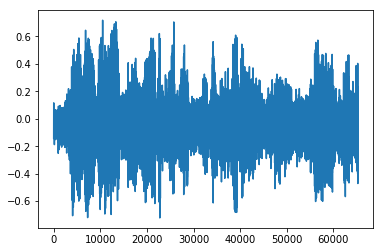

In [12]:
#  The original mixture

plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

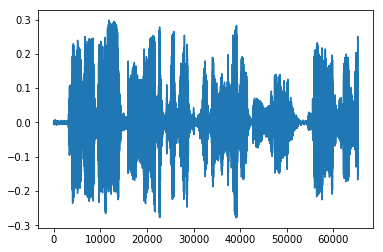

In [13]:
#  The original isolated voice
plt.plot(x,voice_ref_wave[i])
ipd.Audio(voice_ref_wave[i].T, rate=sample_rate)

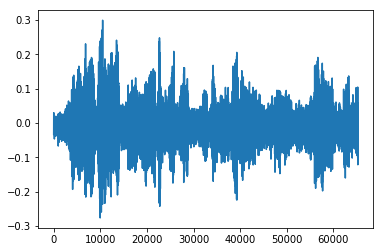

In [14]:
#  The estimated isolated voice produced by the network
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i], rate=sample_rate)

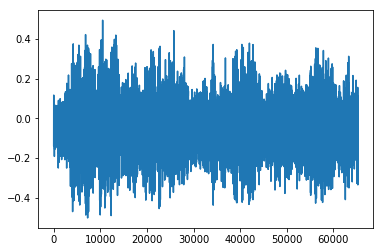

In [15]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])

plt.plot(x,(mix_wave[i]-voice_ref_wave[i]))
ipd.Audio((mix_wave[i]-voice_ref_wave[i]).T, rate=sample_rate)

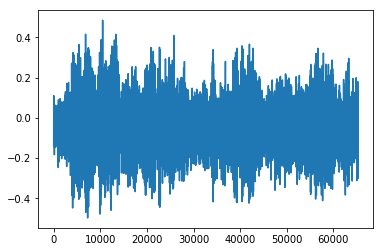

In [31]:
#  The reference background noise, by subtracting magnitude spectrograms
plt.plot(x,bg_ref_wave[i])
ipd.Audio(bg_ref_wave[i].T, rate=sample_rate)

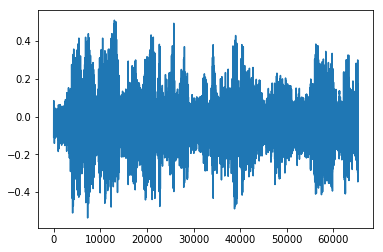

In [32]:
#  The reference background noise, by subtracting magnitude spectrograms
plt.plot(x,bg_est_wave[i])
ipd.Audio(bg_est_wave[i].T, rate=sample_rate)

#### Save an audio example to file if required

In [ ]:
import sounfile as sf
new_file_path = ''
audio = 
sf.write(new_file_path, audio, sample_rate=sample_rate)